<a href="https://colab.research.google.com/github/cryingjin/Today-I-Learned/blob/master/Covid19_Drugs0812.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/My Drive/Daewoong

/content/drive/My Drive/Daewoong


In [2]:
# ready
import pandas as pd
import numpy as np
import glob
import json
from tqdm import tqdm
import pickle
import string

# visualize modules 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette("hls")
import warnings
warnings.filterwarnings('ignore')
# plt.style.use('ggplot') 더 예쁜 seaborn 사용

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Pickle 불러오기
with open('COVID19_assignment1.pickle','rb') as fr:
    data = pickle.load(fr)
data.head(2)     

,paper_id,doi,abstract,body_text,publish_time,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
27,001c739361ad2fadb6f2d22f14dfe23e772eb5b1,10.3390/diagnostics10060399,The current coronavirus disease 2019 pandemic ...,"On 30 January 2020, the World Health Organizat...",2020-06-11,"James, Ameh S.. Alwneh, John I.",COVID-19 Infection Diagnosis: Potential<b...,Diagnostics (Basel),The current coronavirus disease 2019 pa...,1614,38904,78
31,0020e5c796f50e927b96ff0b7ea375b4745261a3,10.1186/s12887-020-02112-x,Background: One major limitation for less inva...,Respiratory Distress Syndrome (RDS) affects 85...,2020-05-08,"Chevallier, Marie. Durrmeyer, Xavier. ...",Propofol versus placebo (with rescue wi...,BMC Pediatr,Background: One major limitation for le...,286,25663,81


In [4]:
# paper_id -> doc_id 로 변경
data.rename(columns = {"paper_id": "doc_id"}, inplace = True)

In [5]:
df = data.copy()
df.head(1)

,doc_id,doi,abstract,body_text,publish_time,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
27,001c739361ad2fadb6f2d22f14dfe23e772eb5b1,10.3390/diagnostics10060399,The current coronavirus disease 2019 pandemic ...,"On 30 January 2020, the World Health Organizat...",2020-06-11,"James, Ameh S.. Alwneh, John I.",COVID-19 Infection Diagnosis: Potential<b...,Diagnostics (Basel),The current coronavirus disease 2019 pa...,1614,38904,78


In [6]:
def doi_to_url(doi):
    if isinstance(doi, float):
        return None
    elif doi.startswith('http'):
        return str(doi)
    elif doi.startswith('doi'):
        return 'https://' + str(doi)
    else:
        return 'https://doi.org/' + str(doi)

In [7]:
df['url'] = df.doi.apply(doi_to_url)
df.head(3)

,doc_id,doi,abstract,body_text,publish_time,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,url
27,001c739361ad2fadb6f2d22f14dfe23e772eb5b1,10.3390/diagnostics10060399,The current coronavirus disease 2019 pandemic ...,"On 30 January 2020, the World Health Organizat...",2020-06-11,"James, Ameh S.. Alwneh, John I.",COVID-19 Infection Diagnosis: Potential<b...,Diagnostics (Basel),The current coronavirus disease 2019 pa...,1614,38904,78,https://doi.org/10.3390/diagnostics10060399
31,0020e5c796f50e927b96ff0b7ea375b4745261a3,10.1186/s12887-020-02112-x,Background: One major limitation for less inva...,Respiratory Distress Syndrome (RDS) affects 85...,2020-05-08,"Chevallier, Marie. Durrmeyer, Xavier. ...",Propofol versus placebo (with rescue wi...,BMC Pediatr,Background: One major limitation for le...,286,25663,81,https://doi.org/10.1186/s12887-020-02112-x
33,00218ecac4058261da156a6848e05e72f77b4dfc,10.1016/s2213-8587(20)30155-8,www.thelancet.com/diabetes-endocrinology Publi...,In the current coronavirus disease 2019 (COVID...,2020-05-05,"Danne, Thomas. Limbert, Catarina","COVID-19, type 1 diabetes, and technolo...",Lancet Diabetes Endocrinol,www.thelancet.com/diabetes-endocrinology<br>...,82,9270,70,https://doi.org/10.1016/s2213-8587(20)30155-8


# COVID-19 관련 약물 추출 00812

* pre-filter by covid-19

In [8]:
covid19_names = {
    'COVID19',
    'COVID-19',
    '2019-nCoV',
    '2019-nCoV.',
    'coronavirus disease 2019',
    'Corona Virus Disease 2019',
    '2019-novel Coronavirus',
    'SARS-CoV-2',
}

def has_covid19(text):
    for name in covid19_names:
        if text and name.lower() in text.lower():
            return True
    return False

df['title_has_covid19'] = df.title.apply(has_covid19)
df['abstract_has_covid19'] = df.abstract.apply(has_covid19)
# df['body_has_covid19'] = df.body.apply(has_covid19)
df_covid19 = df[df.title_has_covid19 | df.abstract_has_covid19]
print(df_covid19.shape)     # (5849, 14)

(5849, 15)


In [9]:
df_covid19.head(2)

,doc_id,doi,abstract,body_text,publish_time,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,url,title_has_covid19,abstract_has_covid19
27,001c739361ad2fadb6f2d22f14dfe23e772eb5b1,10.3390/diagnostics10060399,The current coronavirus disease 2019 pandemic ...,"On 30 January 2020, the World Health Organizat...",2020-06-11,"James, Ameh S.. Alwneh, John I.",COVID-19 Infection Diagnosis: Potential<b...,Diagnostics (Basel),The current coronavirus disease 2019 pa...,1614,38904,78,https://doi.org/10.3390/diagnostics10060399,True,True
33,00218ecac4058261da156a6848e05e72f77b4dfc,10.1016/s2213-8587(20)30155-8,www.thelancet.com/diabetes-endocrinology Publi...,In the current coronavirus disease 2019 (COVID...,2020-05-05,"Danne, Thomas. Limbert, Catarina","COVID-19, type 1 diabetes, and technolo...",Lancet Diabetes Endocrinol,www.thelancet.com/diabetes-endocrinology<br>...,82,9270,70,https://doi.org/10.1016/s2213-8587(20)30155-8,True,False


* nlp 처리

In [10]:
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz

In [11]:
#!pip install py3Dmol
#!pip install -U chembl_webresource_client

In [12]:
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
#!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
#!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [13]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher
import en_ner_bc5cdr_md
import os
from collections import Counter
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol # Amazing library for 3D visualization
from rdkit import Chem
from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed
from IPython.display import Image
import cv2
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans
import gc

In [14]:
nlp = en_ner_bc5cdr_md.load()

In [15]:
def apply_spacy(texts, nlp):
    docs = []
    for t in texts:
        if t:
            docs.append(nlp(t))
        else:
            docs.append(None)
    return docs

In [16]:
def annotate_with_spacy(df):
    df['title_doc'] = apply_spacy(df.title, nlp)
    df['abstract_doc'] = apply_spacy(df.abstract, nlp)
    return df

def get_spacy_df(df):
    try:
        with open('df_spacy_cache.pickle', 'rb') as f:
            df_spacy = pickle.load(f)
    except FileNotFoundError:
        df_spacy = annotate_with_spacy(df)
        with open('df_spacy_cache.pickle', 'wb') as f:
            pickle.dump(df_spacy, f)
    return df_spacy

In [17]:
df_spacy = get_spacy_df(df_covid19)
df_spacy.iloc[0].abstract_doc.ents

(coronavirus disease, Coronavirus, 2019-nCoV, SARS-CoV-2, SARS-CoV-2)

In [18]:
df_spacy

,doc_id,doi,abstract,body_text,publish_time,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,url,title_has_covid19,abstract_has_covid19,title_doc,abstract_doc
27,001c739361ad2fadb6f2d22f14dfe23e772eb5b1,10.3390/diagnostics10060399,The current coronavirus disease 2019 pandemic ...,"On 30 January 2020, the World Health Organizat...",2020-06-11,"James, Ameh S.. Alwneh, John I.",COVID-19 Infection Diagnosis: Potential<b...,Diagnostics (Basel),The current coronavirus disease 2019 pa...,1614,38904,78,https://doi.org/10.3390/diagnostics10060399,True,True,"( , COVID-19, , Infection, , Diagnosis, :, ...","(The, current, coronavirus, disease, 2019, pan..."
33,00218ecac4058261da156a6848e05e72f77b4dfc,10.1016/s2213-8587(20)30155-8,www.thelancet.com/diabetes-endocrinology Publi...,In the current coronavirus disease 2019 (COVID...,2020-05-05,"Danne, Thomas. Limbert, Catarina","COVID-19, type 1 diabetes, and technolo...",Lancet Diabetes Endocrinol,www.thelancet.com/diabetes-endocrinology<br>...,82,9270,70,https://doi.org/10.1016/s2213-8587(20)30155-8,True,False,"( , COVID-19, ,, , type, , 1, , diabetes, ...","(www.thelancet.com/diabetes-endocrinology, Pub..."
39,00286c2b94f42979d234bd4070fba1d82006e61b,10.1016/j.jamda.2020.06.013,5 Objective: To assess the American Testing Gu...,A wide testing strategy is effective in detect...,2020-06-11,"Blain, Hubert. Rolland, Yves. Tuaill...",Efficacy of a Test-Retest Strategy in<b...,J Am Med Dir Assoc,5 Objective: To assess the American Te...,262,5558,65,https://doi.org/10.1016/j.jamda.2020.06.013,True,True,"( , Efficacy, , of, , a, , Test-Retest, ,...","(5, Objective, :, To, assess, the, American, T..."
52,00301013bb6798789524592b73c6596ffa5b0603,10.1007/s43441-020-00160-0,FDA guidances are typically first released in ...,FDA guidances are typically first released in ...,2020-05-09,"Turner, J. Rick",New FDA Guidance on General Clinical T...,Drug Inf J,FDA guidances are typically first relea...,626,4529,64,https://doi.org/10.1007/s43441-020-00160-0,True,False,"( , New, , FDA, , Guidance, , on, , Gener...","(FDA, guidances, are, typically, first, releas..."
68,003c6f5c9b38f7d29898a7dc9554d5a7489f9431,10.1007/s12630-020-01684-7,Background The severe acute respiratory syndro...,patients each for the PEP and PET trials. Part...,2020-05-07,"Lother, Sylvain A.. Abassi, Mahsa. ...",Post-exposure prophylaxis or pre-emptive<...,Can J Anaesth,Background The severe acute respiratory<...,848,30565,78,https://doi.org/10.1007/s12630-020-01684-7,True,True,"( , Post-exposure, , prophylaxis, , or, , ...","(Background, The, severe, acute, respiratory, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63755,ffde285d8c4a8cb3f21e3923bb0512bde69f884f,10.1101/2020.06.25.170936,Diabetes is one of the most critical comorbidi...,"Since its appearance in late 2019, the COVID-1...",2020-06-25,"Hachim, Mahmood Yaseen. Hachim, Ibrahi...",Cellular exocytosis gene (EXOC6/6B): a<b...,bioRxiv,Diabetes is one of the most critical<b...,1468,15102,78,https://doi.org/10.1101/2020.06.25.170936,True,True,"( , Cellular, , exocytosis, , gene, , (, E...","(Diabetes, is, one, of, the, most, critical, c..."
63763,ffe2156eae2e795ce8546944bc07cd8e1df073f4,10.1186/s42358-020-00134-8,"Hydroxychloroquine and chloroquine, also known...","Hydroxychloroquine (HCQ) and chloroquine (CQ),...",2020-06-09,"dos Reis Neto, Edgard Torres. Kakehas...",Revisiting hydroxychloroquine and<br>chlor...,Adv Rheumatol,"Hydroxychloroquine and chloroquine, also<...",743,25909,81,https://doi.org/10.1186/s42358-020-00134-8,False,True,"( , Revisiting, , hydroxychloroquine, , and...","(Hydroxychloroquine, and, chloroquine, ,, also..."
63776,ffe9ca8d06f53d3b2c6ab8cc9bb56f8ec7e47506,10.1016/j.brs.2020.05.010,Background: The COVID-19 pandemic has broadly ...,COVID-19 was first recognized in December 2019...,2020-05-12,"Bikson, Marom. Hanlon, Colleen A.. ...",Guidelines for TMS/tES Clinical Services...,Brain St

In [19]:
trial_indicators = {
    'trial',
    'study',
    'experiment',
    'evaluate',
    'evaluation',
    're-evaluate',
    'report',
    'test',
    'testing',
    'target',
    'data',
    'show',
    'outcome',
    'evaluation',
    'find',
    'agent',
    
}

usage_indicators = {
    'approve',
    'approval',
    'therapeutic',
    'therapy',
    'inhibitory',
    'effect',
    'administer',
    'achieve',
    'improve'
    'alleviate',
    'reduce',
    'antiviral',
    'against',
    'suppress',
    'beneficial',
    'evidence',
    'take',
    'prescribe',
    'treatment',
    'receive',
    'treat',
    'regimen',
    'therapy',
    'use',
    'efficacy',
    'course',
    'drug',
}

idea_indicators = {
    'promising',
    'promise',
    'speculate',
    'believe',
    'would',
    'could',
    'may',
    'possibly',
    'might',
    'should',
    'hypothesize',
    'appear',
    'lack',
    'unclear',
    'need',
} 

matcher = Matcher(nlp.vocab)
for n in trial_indicators:
    matcher.add("trial", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in usage_indicators:
    matcher.add("usage", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in idea_indicators:
    matcher.add("idea", None, [{'LEMMA': w.lemma_} for w in nlp(n)])

example_sent = "Clinical trials (for example, ChiCTR2000029539) have been initiated to test HIV protease inhibitors such as lopinavir and ritonavir in patients infected with 2019-nCoV."
doc = nlp(example_sent)
matches = matcher(doc)
for match_name, start, end in matches:
    print(nlp.vocab.strings[match_name], ':', doc[start:end])

trial : trials
trial : test


In [20]:
def doc_to_matches(doc):
    match_results = {
        'trial': [],
        'usage': [],
        'idea': []
    }
    if not doc:
        return match_results

    matches = matcher(doc)
    for match_id, start, end in matches:
        match_name = nlp.vocab.strings[match_id]
        match_results[match_name].append((start, end))
    return match_results

def get_matches_df(docs):
    matches = []
    for doc in docs:
        matches.append(doc_to_matches(doc))
    df = pd.DataFrame(matches)
    return df
        
df_matches = get_matches_df(df_spacy.abstract_doc)
df_matches.columns = ['abstract_trial_matches', 'abstract_usage_matches', 'abstract_idea_matches']
df_with_matches = pd.concat([df_spacy.reset_index(drop=True), df_matches], axis=1)
df_with_matches.head(3)

,doc_id,doi,abstract,body_text,publish_time,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,url,title_has_covid19,abstract_has_covid19,title_doc,abstract_doc,abstract_trial_matches,abstract_usage_matches,abstract_idea_matches
0,001c739361ad2fadb6f2d22f14dfe23e772eb5b1,10.3390/diagnostics10060399,The current coronavirus disease 2019 pandemic ...,"On 30 January 2020, the World Health Organizat...",2020-06-11,"James, Ameh S.. Alwneh, John I.",COVID-19 Infection Diagnosis: Potential<b...,Diagnostics (Basel),The current coronavirus disease 2019 pa...,1614,38904,78,https://doi.org/10.3390/diagnostics10060399,True,True,"( , COVID-19, , Infection, , Diagnosis, :, ...","(The, current, coronavirus, disease, 2019, pan...","[(32, 33), (43, 44), (164, 165), (174, 175)]",[],"[(44, 45), (100, 101), (140, 141), (181, 182),..."
1,00218ecac4058261da156a6848e05e72f77b4dfc,10.1016/s2213-8587(20)30155-8,www.thelancet.com/diabetes-endocrinology Publi...,In the current coronavirus disease 2019 (COVID...,2020-05-05,"Danne, Thomas. Limbert, Catarina","COVID-19, type 1 diabetes, and technolo...",Lancet Diabetes Endocrinol,www.thelancet.com/diabetes-endocrinology<br>...,82,9270,70,https://doi.org/10.1016/s2213-8587(20)30155-8,True,False,"( , COVID-19, ,, , type, , 1, , diabetes, ...","(www.thelancet.com/diabetes-endocrinology, Pub...",[],[],[]
2,00286c2b94f42979d234bd4070fba1d82006e61b,10.1016/j.jamda.2020.06.013,5 Objective: To assess the American Testing Gu...,A wide testing strategy is effective in detect...,2020-06-11,"Blain, Hubert. Rolland, Yves. Tuaill...",Efficacy of a Test-Retest Strategy in<b...,J Am Med Dir Assoc,5 Objective: To assess the American Te...,262,5558,65,https://doi.org/10.1016/j.jamda.2020.06.013,True,True,"( , Efficacy, , of, , a, , Test-Retest, ,...","(5, Objective, :, To, assess, the, American, T...",[],[],[]


In [21]:
# df_covid19 = df_with_matches[df_with_matches.abstract_has_covid19]
print('Example abstracts', df_with_matches.shape)
for i, row in list(df_with_matches.iterrows())[:5]:
    print('TITLE:', row.title)
    print('\n')
    print(row.abstract)
    print('\n', '-' * 50, '\n')

Example abstracts (5849, 20)
TITLE:   COVID-19  Infection  Diagnosis:  Potential<br>Impact  of  Isothermal  Amplification  Technology  to<br>Reduce  Community  Transmission  of  SARS-CoV-2


The current coronavirus disease 2019 pandemic is largely driven by community transmission, after 2019 novel Coronavirus (2019-nCoV or SARS-CoV-2) crosses the borders. To stop the spread, rapid testing is required at community clinics and hospitals. These rapid tests should be comparable with the standard PCR technology. Isothermal amplification technology provides an excellent alternative that is highly amenable to resource limited settings, where expertise and infrastructure to support PCR are not available. In this review, we provide a brief description of isothermal amplification technology, its potential and the gaps that need to be considered for SARS-CoV-2 detection. Among this emerging technology, loop-mediated amplification (LAMP), recombinase polymerase amplification (RPA) and Nicking enzy

* Extract all drugs and therapeutics from abstracts

Count Frequencies

{'hydroxychloroquine': 246, 'HCQ': 228, 'chloroquine': 120, 'CQ': 119, 'vitamin D': 97, 'angiotensin': 90, 'Covid-19': 81, 'angiotensin II': 81, 'azithromycin': 75, 'heparin': 62, 'ARBs': 61, 'lockdown': 60, 'Remdesivir': 53, 'lopinavir/ritonavir': 51, 'corticosteroids': 47, 'Hydroxychloroquine': 46, 'glucose': 44, 'Chloroquine': 39, 'favipiravir': 39, 'ARB': 37, 'ozone': 34, 'ACEI/ARB': 34, 'ACEIs': 33, 'D614G': 33, 'ivermectin': 29, 'K': 27, 'anti-SARS-CoV-2': 27, '−': 27, 'COVID-19': 26, 'aspartate': 26, 'spine': 25, 'STL': 24, 'telepsychology': 24, 'TCZ': 23, 'TNF-α': 22, 'Vitamin D': 22, 'iron': 22, 'AZ': 21, 'creatine': 21, 'Angiotensin': 21, 'hydrogen': 21, 'MPA': 21, 'alanine': 20, 'SARS-CoV2 infection': 20, 'nucleoside': 20, 'steroids': 19, 'IMV': 19, 'MSCs': 19, 'glucocorticoids': 19, 'glycerol': 18, 'Sars-CoV-2': 18, 'non-COVID-19': 18, 'metformin': 18, 'ritonavir': 17, 'ethanol': 17, 'WhatsApp': 17, 'methylprednisolone': 17, 'troponin': 17, 'hydrogen pero

<BarContainer object of 152 artists>

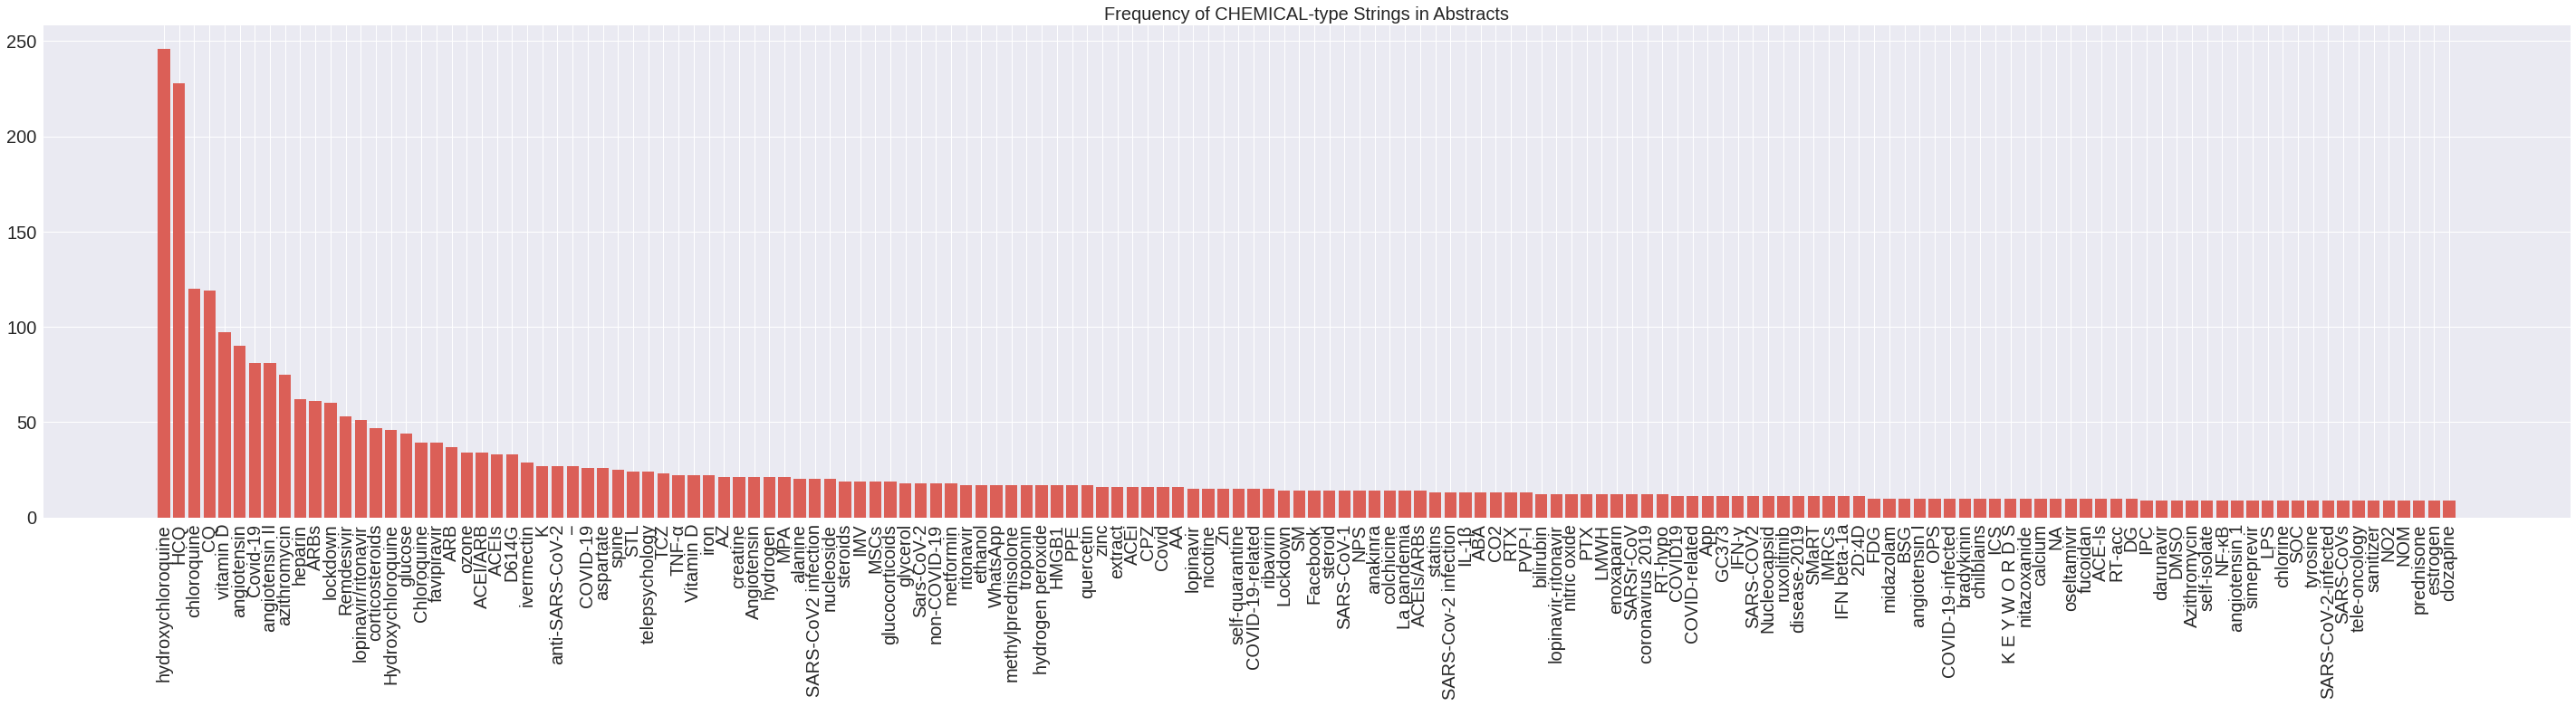

In [27]:
BLACKLIST = {
 'ACE2s',
 '2019-nCoV',
 '95%CI',
 'ACE2-Fc',
 'AMB',
 'AMI',
 'AMK',
 'AOM',
 'AST-045',
 'AST-N041',
 'ATP',
 'BPO3-P',
 'Betacoronavirus',
 'CAP',
 'CAZ',
 'CC',
 'CIP',
 'CP',
 'CLAVE',
 'COVID-2019',
 'CR3022',
 'creatinine', 
 'CTX',
 'CTX-M',
 'CoV-2',
 'DES',
 'DHPG',
 'DIP',
 'E2',
 'ESBL',
 'Enterobacteriaceae',
 'FASTA',
 'FCA',
 'FCS',
 'FOS',
 'GEN',
 'GM',
 'HK',
 'HPDI',
 'IFR',
 'IM',
 'IVA',
 'JA',
 'KLK13',
 'LA',
 'LPV/r',
 'LYM%',
 'La',
 'LcS',
 'Li',
 'MERS-CoV.',
 'MICs',
 'Metapneumovirus',
 'Médecine',
 'NAL',
 'NCP',
 'NG',
 'NLR',
 'NO',
 'NOR',
 'NP',
 'NS7b',
 'OC',
 'OFL',
 'OP',
 'Prefixes',
 'Résumé',
 'S.',
 'SARS-CoV-2',
 'SARS-COV-2',
 'SARS-Cov2',
 'SARS-CoV2',
 'SARS-CoV-2 infection',
 'SARS-CoV-2 infections',
 'SARS-CoV-2 pneumonia',
 'SARS-CoV.',
 'SARS-Cov-2',
 'SARS-related',
 'SGC7901',
 'SHV',
 'SP',
 'Sarbecovirus',
 'Se',
 'TCM',
 'TCR',
 'TCB',
 'TGEV',
 'TOB',
 'TSL-EO',
 'Texte',
 'VME',
 'VP',
 'WeChat',
 'ZJ01',
 '[ST]A',
 'alcohol',
 'amino acid',
 'amino acids',
 'aminoglycosides',
 'bat-SL-CoVZXC21',
 'betacoronavirus',
 'cholesterol',
 'coronavirus',
 'des cas',
 'https://doi.org/10',
 'infector-infectee',
 "l'origine",
 'lactate',
 'lockdowns',
 'na',
 'nucleic acid',
 'nucleic acids',
 'nucleotide',
 'NBCZone',
 'oxygen',
 'quinolones',
 'rinitis',
 'self-imposed',
 'sodium',
 'smoking',
 'β-coronavirus',
 '℃'}


def count_chemical_ents(df):
    ent_str = []
    for i, row in df.iterrows():
        if row.abstract_doc:            
            for ent in row.abstract_doc.ents:
                if ent.label_ == 'CHEMICAL':
                    ent_str.append(row.abstract_doc[ent.start:ent.end].text)
            
    filtered = [e for e in Counter(ent_str).most_common() if e[1] > 8 and e[0] not in BLACKLIST]
    return dict(filtered)

counts = count_chemical_ents(df_with_matches)
print('Count Frequencies\n')
print(counts)

plt.figure(figsize=(50,10))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xticks(rotation=90)
plt.title('Frequency of CHEMICAL-type Strings in Abstracts', fontsize=20)
plt.bar(counts.keys(), counts.values())

* Molecular Structure

In [28]:
def doc_id_to_link(doc_id, df_meta, df_data):
    rows = df_meta
    if rows.empty:
        return 'UNKNOWN URL AND TITLE'
    url = rows.iloc[0].url
    title = rows.iloc[0].title
    if url and title:
        return '<a href="{}">'.format(url) + title + '</a>'
    elif title:
        return title
    elif url:
        return '<a href="{}">'.format(url) + 'UNKNOWN TITLE' + '</a>'
    else:
        return 'UNKNOWN URL AND TITLE'

def chemical_df(chemicals, df_data, df_meta):
    rows = []    
    for chem in chemicals:
        chem_row = {
            'chemical_name': chem,
            'chemical': [],
            'trials': [],
            'usages': [],
            'ideas': []
        }
        matcher = Matcher(nlp.vocab)
        matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(chem)])
        for i, row in df_data.iterrows():
            chem_matches = matcher(row.abstract_doc)
            for chem_match in chem_matches:
                chem_row['chemical'].append((row.doc_id, chem_match[1], chem_match[2]))
                for trial_match in row.abstract_trial_matches:
                    if abs(trial_match[1] - chem_match[1]) < 15:
                        chem_row['trials'].append((row.doc_id, trial_match[0], trial_match[1]))
                for usage_match in row.abstract_usage_matches:
                    if abs(usage_match[1] - chem_match[1]) < 15:
                        chem_row['usages'].append((row.doc_id, usage_match[0], usage_match[1]))
                for idea_match in row.abstract_idea_matches:
                    if abs(idea_match[1] - chem_match[1]) < 15:
                        chem_row['ideas'].append((row.doc_id, idea_match[0], idea_match[1]))
        rows.append(chem_row)
    return pd.DataFrame(rows)
        
    
df_chemical = chemical_df(list(counts.keys()), df_with_matches, data)
df_chemical.head(3)

,chemical_name,chemical,trials,usages,ideas
0,hydroxychloroquine,"[(003c6f5c9b38f7d29898a7dc9554d5a7489f9431, 61...","[(003c6f5c9b38f7d29898a7dc9554d5a7489f9431, 59...","[(003c6f5c9b38f7d29898a7dc9554d5a7489f9431, 70...","[(0abcdbdc4d50e397e4e0d9afba1c401ad4e14294, 42..."
1,HCQ,[],[],[],[]
2,chloroquine,"[(0053d87ffc098edc24578b426b099974cbef7b3a, 19...","[(01a59c5ac31e5e7bcef81caa0a2af030968e186c, 92...","[(0053d87ffc098edc24578b426b099974cbef7b3a, 19...","[(01a59c5ac31e5e7bcef81caa0a2af030968e186c, 32..."


In [29]:
# function to draw the molecule
def drawit(m,p,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
p = py3Dmol.view(width=400,height=400)


In [30]:
# get the top drugs most mencioned
listchemicals = df_chemical.chemical_name.replace('lopinavir/ritonavir', 'lopinavir').head(25)
listchemicals

0     hydroxychloroquine
1                    HCQ
2            chloroquine
3                     CQ
4              vitamin D
5            angiotensin
6               Covid-19
7         angiotensin II
8           azithromycin
9                heparin
10                  ARBs
11              lockdown
12            Remdesivir
13             lopinavir
14       corticosteroids
15    Hydroxychloroquine
16               glucose
17           Chloroquine
18           favipiravir
19                   ARB
20                 ozone
21              ACEI/ARB
22                 ACEIs
23                 D614G
24            ivermectin
Name: chemical_name, dtype: object

In [31]:
# Create clusters
listMols2 = []
listValids = []

for i in range(len(listchemicals)):
    try:
        productName = listchemicals[i]
        
        # Initiate Chembl database client
        molecule = new_client.molecule
        # get the moelcule id
        molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
        res = molecule.get(molecule_chembl_id)
        # return smile format molecular structure
        smileStruct = res['molecule_structures']['canonical_smiles']
        # converto to mol format
        m = Chem.MolFromSmiles(smileStruct)
        m = Chem.AddHs(m)
        listMols2.append(m)
        listValids.append(productName)
      
    except Exception as e:
        print(f'\nSorry, impossible to create structure for {productName}.')
        
        
# generate fingeprints: Morgan fingerprint with radius 2
n_dimensions = 300
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, n_dimensions) for m in listMols2]
# Convert to numpy array
np_fps = np.asarray(fps)

############# PCA decomposition (n=3)  #######################
centers = [[1, 1], [-1, -1], [1, -1]]
X = np_fps
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
df2 = pd.DataFrame(X ,columns=['principal_component_1','principal_component_2','principal_component_3'])
df2['names'] = pd.DataFrame(listValids)

############# Kmeans clusters  #######################
kmeansmodel = KMeans(n_clusters=8).fit(df2[df2.columns[0:3]])
labelKmeans = kmeansmodel.labels_.astype(float)
df2['cluster'] = labelKmeans


Sorry, impossible to create structure for CQ.

Sorry, impossible to create structure for Covid-19.

Sorry, impossible to create structure for heparin.

Sorry, impossible to create structure for lockdown.

Sorry, impossible to create structure for ACEIs.

Sorry, impossible to create structure for D614G.


In [32]:
# Remove duplicated compounds
df2 = df2.drop_duplicates(subset=['principal_component_1','principal_component_2','principal_component_3'])
df2.sort_values(by=['cluster'])

,principal_component_1,principal_component_2,principal_component_3,names,cluster
6,-1.655766,-2.484044,-2.116459,azithromycin,0.0
8,-1.394757,-2.486038,-1.227610,Remdesivir,0.0
10,-1.539935,-1.627710,-1.508566,corticosteroids,0.0
7,-2.594290,4.807742,-0.130546,ARBs,1.0
0,4.319844,0.218613,0.576397,hydroxychloroquine,2.0
2,4.079920,0.577639,0.940840,chloroquine,2.0
4,-2.543231,-2.023131,5.351435,angiotensin,3.0
5,-2.851072,-2.081557,5.464738,angiotensin II,3.0
3,-0.747261,-1.174498,-2.520171,vitamin D,4.0
12,-0.115726,-0.802548,-2.209294,glucose,4.0


In [33]:
# Gabarge collector to liberate memory
gc.collect()

508

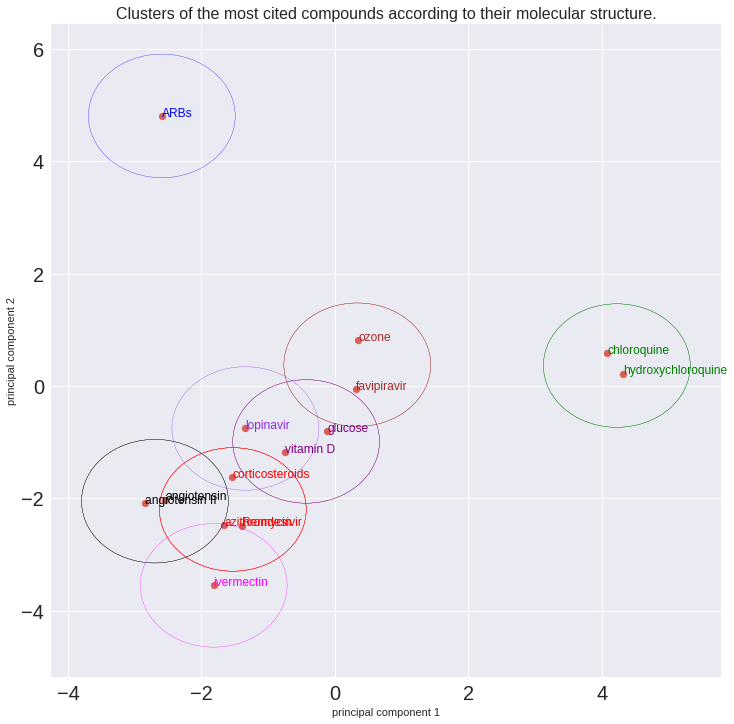

In [34]:
############# Scatter plot  #######################
import matplotlib.patches as mpatches

centroids  = kmeansmodel.cluster_centers_

def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

xs = df2.principal_component_1
ys = df2.principal_component_2
names = df2.names
cluster = df2.cluster
ax.scatter(xs, ys)
radius = 1.1

for x,y,names,cluster in zip(xs,ys,names,cluster):
    label = names
    if cluster == 0:
        ax.text(x, y, label, fontsize=12, color='red')
        art = mpatches.Circle(centroids[0],radius, edgecolor='r',fill=False)
        ax.add_patch(art)
    if cluster == 1:
        ax.text(x, y, label,fontsize=12, color='blue')
        art = mpatches.Circle(centroids[1],radius, edgecolor='blue',fill=False)
        ax.add_patch(art)        
    if cluster == 2:
        ax.text(x, y, label, fontsize=12, color='green')
        art = mpatches.Circle(centroids[2],radius, edgecolor='green',fill=False)
        ax.add_patch(art)        
    if cluster == 3:
        ax.text(x, y, label, fontsize=12, color='black') 
        art = mpatches.Circle(centroids[3],radius, edgecolor='black',fill=False)
        ax.add_patch(art)        
    if cluster == 4:
        ax.text(x, y, label, fontsize=12, color='purple')
        art = mpatches.Circle(centroids[4],radius, edgecolor='purple',fill=False)
        ax.add_patch(art)        
    if cluster == 5:
        ax.text(x, y, label, fontsize=12, color='blueviolet') 
        art = mpatches.Circle(centroids[5],radius, edgecolor='blueviolet',fill=False)
        ax.add_patch(art)        
    if cluster == 6:
        ax.text(x, y, label, fontsize=12, color='brown') 
        art = mpatches.Circle(centroids[6],radius, edgecolor='brown',fill=False)
        ax.add_patch(art)        
    if cluster == 7:
        ax.text(x, y, label, fontsize=12, color='magenta')  
        art = mpatches.Circle(centroids[7],radius, edgecolor='magenta',fill=False)
        ax.add_patch(art)        
    
      

ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.title('Clusters of the most cited compounds according to their molecular structure.', loc='center', pad=None, fontSize=16)
plt.show()

In [35]:
# get the top drugs most mencioned
listchemicals = listchemicals.head(6)
listchemicals

0    hydroxychloroquine
1                   HCQ
2           chloroquine
3                    CQ
4             vitamin D
5           angiotensin
Name: chemical_name, dtype: object

In [ ]:
listchemicals

In [36]:
percentSimilarity = 85

def print_structures(productName):
    try:

        print('\n..................................................................................')
        print(f'\nStructure of {productName}\n')

        ################## Find the molecular structure in Chembl database ###########################

        # Initiate Chembl database client
        molecule = new_client.molecule
        # get the moelcule id
        molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
        res = molecule.get(molecule_chembl_id)
        # return smile format molecular structure
        smileStruct = res['molecule_structures']['canonical_smiles']
        # converto to mol format using RDKIT library
        m = Chem.MolFromSmiles(smileStruct)
        m = Chem.AddHs(m)
        # create the molecule image
        AllChem.EmbedMultipleConfs(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
        interact(drawit, m=fixed(m),p=fixed(p));

        ############ Find similar molecules in Chembl database ###################################### 
        print(f'\nMolecules that have at least {percentSimilarity}% similarity with {productName}\n')

        similarity = new_client.similarity
        similar = similarity.filter(chembl_id=molecule_chembl_id, similarity=percentSimilarity)

        list_mols=[]
        list_ref_name = []

        for i in range(len(similar)):

            ref_name = (similar[i]['pref_name'])
            if ref_name is None:
                ref_name = similar[i]['molecule_chembl_id']
    #             print(ref_name)
            smileStruct = Chem.MolFromSmiles(similar[i]['molecule_structures']['canonical_smiles'])
            list_mols.append(smileStruct)
            list_ref_name.append(ref_name)

        ms = [x for x in list_mols if x is not None]

        for m in ms: tmp=AllChem.Compute2DCoords(m)

        img=Draw.MolsToGridImage(ms, molsPerRow=3,subImgSize=(200,200),legends=[x for x in list_ref_name])
        
        fileName = 'related_' + productName + '.png'
        img.save(fileName)
        image = cv2.imread(fileName)        

        plt.figure(figsize=(20, 80))
        plt.ticklabel_format(style = 'plain')
        plt.axis('off')
        plt.imshow(image)
        plt.show()

    except Exception as e:
        print('\nSorry, structure not found in Chembl database.')


HCQ

..................................................................................

Structure of HCQ



interactive(children=(IntSlider(value=-1, description='confId', max=1, min=-3), Output()), _dom_classes=('widg…


Molecules that have at least 85% similarity with HCQ



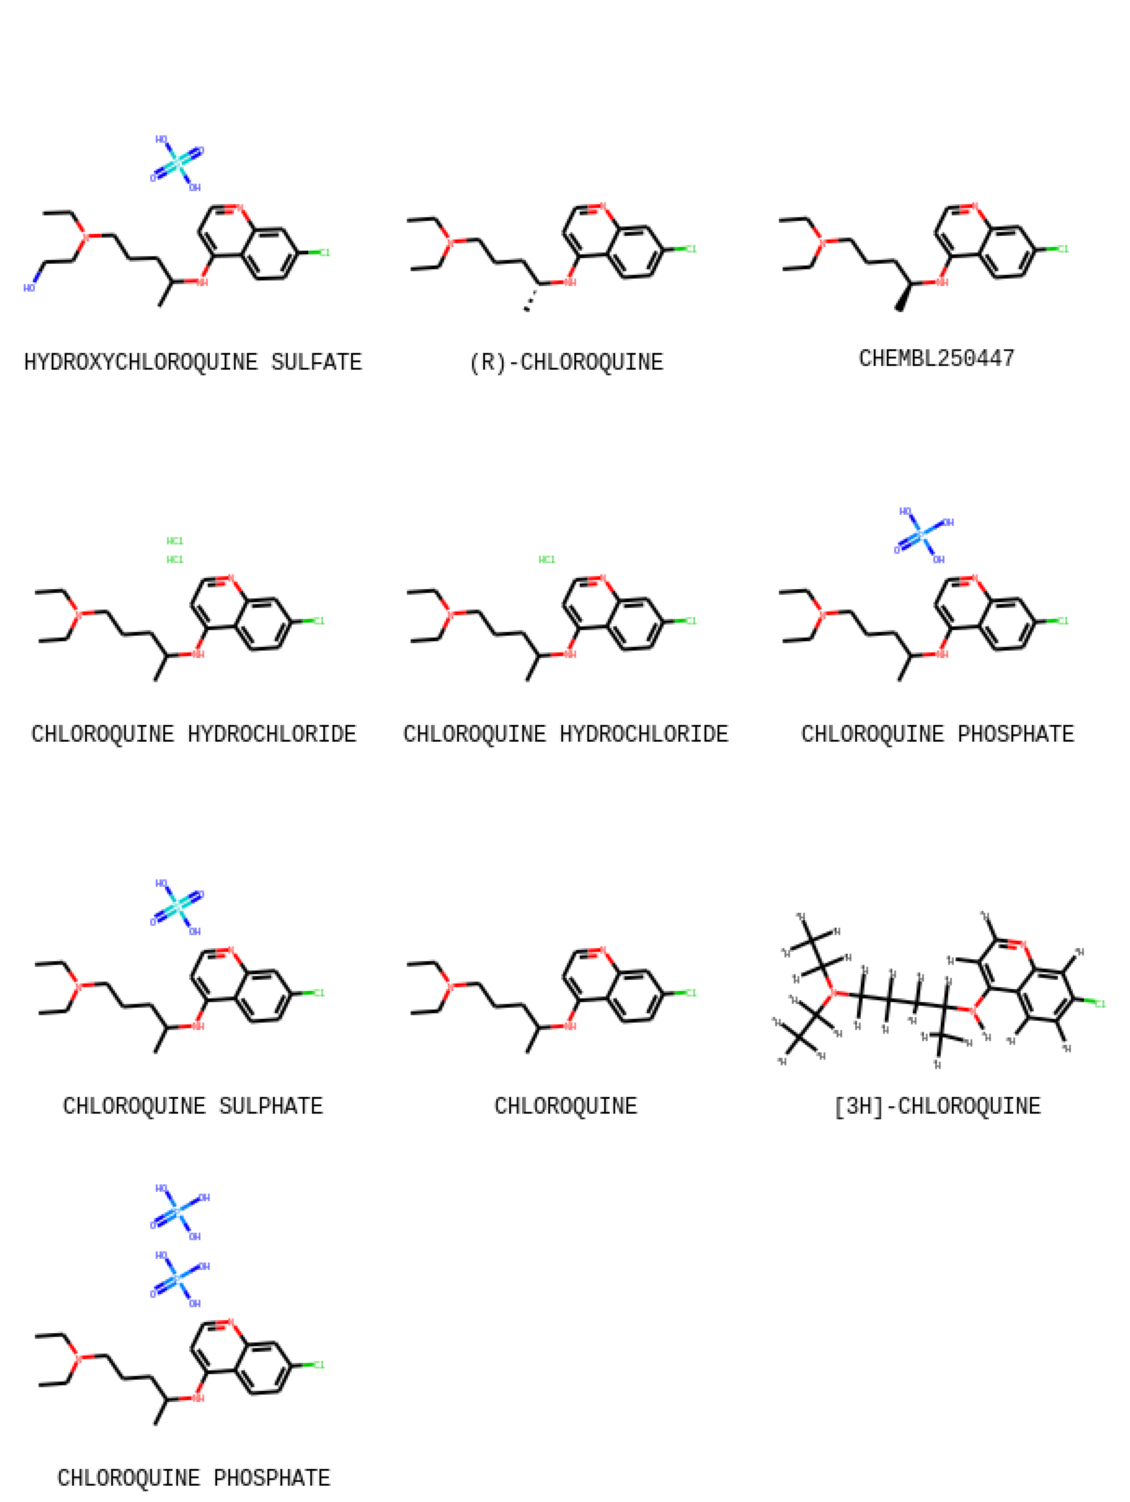

In [40]:
print(listchemicals[1])
print_structures(listchemicals[1])